# Adjusting User-Artist Weights

## Importing Relevant Packages and Datasets

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from functions import *

In [2]:
dataframe_names = [
    'user_friends',
    'user_taggedartists',
    'artists',
    'tags',
    'user_artists']

file_names = [
    '../data/user_friends.csv',
    '../data/user_taggedartists.csv',
    '../data/artists.csv',
    '../data/tags.csv',
    '../data/user_artists.csv']

In [3]:
for (dataframe, file) in zip(dataframe_names, file_names):
    vars()[dataframe] = pd.read_csv(file)

## Exploring the data

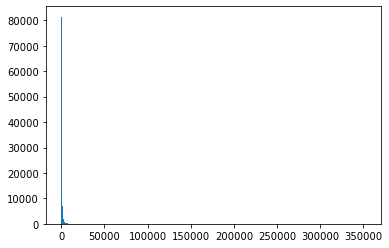

In [4]:
plt.hist(user_artists['weight'], bins=300);

It is difficult to visualise the distribution of the weights using this graph. It is likely that there are few datapoints that go beyond 35,000 and this is causing the rest of the data to be very small and difficult to interpret.

By running some basic commands, I have discovered that 95% of weights are less than or equal to 2,328.

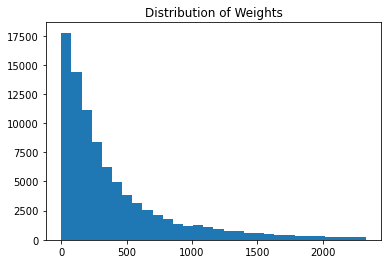

In [5]:
plt.hist(user_artists[user_artists['weight']<=2328]['weight'], bins = 30)
plt.gca().set(title='Distribution of Weights');

This is the new plot where we have excluded any weights over 2,328. 

The graph is much easier to interpret and seems to follow a gamma/exponential distribution.

## Different options

At the moment, it would be quite difficult to seperate the data as it does not follow a normal distribution.

There are different methods we can try to assign a rating for each weight.

### Option 1
Since the distribution of weights has a very long tail, we can find a point where most of the tail is where users gave artists a 5-star rating, and then divide the rest of the weights intuitively/mathematically into 1-4 stars.
This would be to assume a 25% split between 1-star, 2-star, 3-star and 4-star ratings (after we have identified the cut-off poiint for 5-star ratings).

The drawbacks of this option:
- It is not user specific, the percentages (25%) will be the same for all users, except the 5-star rating, which may be disproportionately distributed if someone listens to a huge amount of music.
- It is not accurately representative of natural distribution you'd expect from users liking artists. It is more likely to follow a slight normal distribution where there are more 3 star ratings than 1 or 5 star ratings.

### Option 2
Use a user's average weighting and do a normal distribution seperator. 
1. Do a case study on 10 random people to see the distribution of their weights 
2. If the distribution is normal, follow the standard procedure to separate the ratings, if the distribution is not normal, try to identify if the distribution could be separated in a different way.

The drawbacks of this option:
- It is unlikely that the users' specific weight distribution is normal as the weight distribution as a whole is extremly long-tailed. 
- If we are working with a long-tailed distribution, the method to assign ratings will have to be manually decided and might not be optimal.

<u>Option 2</u> seems like it will yield better results.

We'll firstly investigate the distribution of all users' average weights and then look at 5 users and view their weight distributions in isolation.

## Investigating Users' Average Weight

In [6]:
distribution_of_weights_given = (
    user_artists
    .groupby('weight', as_index=False)
    .agg({'userID': ['mean']})
)

In [7]:
distribution_of_weights_given.columns = ['weight', 'users_avg']

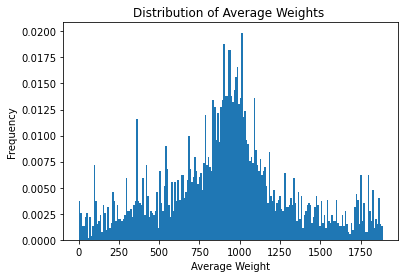

In [8]:
data = distribution_of_weights_given['users_avg']
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=200)
plt.gca().set(
    title='Distribution of Average Weights ', 
    xlabel='Average Weight',
    ylabel='Frequency'
);

This graph shows quite a clear normal distribution, this may be useful to us depending on the specific user distributions.

## Investigating 5 Users' Distributions

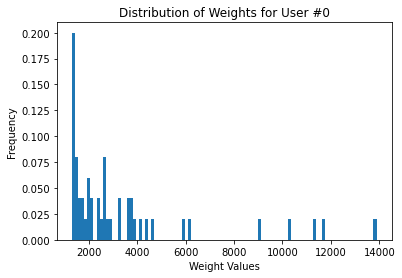

In [9]:
data = user_artists[user_artists['userID']==0]['weight']
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=100)
plt.gca().set(
    title='Distribution of Weights for User #0', 
    xlabel='Weight Values',
    ylabel='Frequency'
);

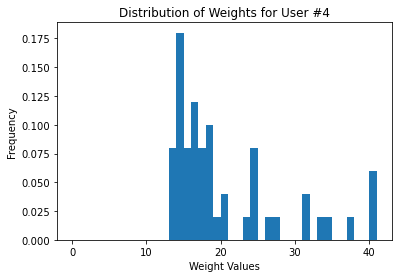

In [10]:
data = user_artists[user_artists['userID']==4]['weight']
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=range(0,42))
plt.gca().set(
    title='Distribution of Weights for User #4', 
    xlabel='Weight Values',
    ylabel='Frequency'
);

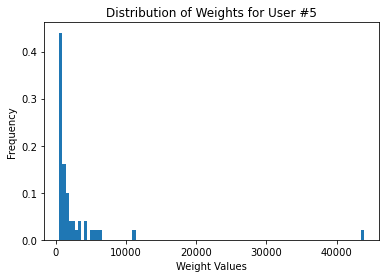

In [11]:
data = user_artists[user_artists['userID']==5]['weight']
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=100)
plt.gca().set(
    title='Distribution of Weights for User #5', 
    xlabel='Weight Values',
    ylabel='Frequency'
);

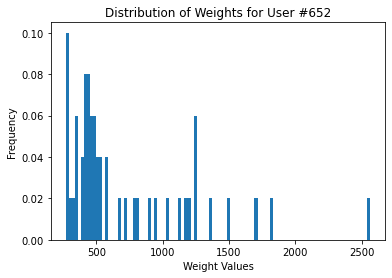

In [12]:
data = user_artists[user_artists['userID']==652]['weight']
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=100)
plt.gca().set(
    title='Distribution of Weights for User #652', 
    xlabel='Weight Values',
    ylabel='Frequency'
);

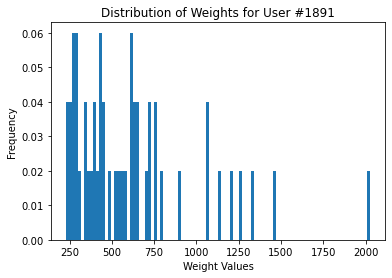

In [13]:
data = user_artists[user_artists['userID']==1891]['weight']
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=100)
plt.gca().set(
    title='Distribution of Weights for User #1891', 
    xlabel='Weight Values',
    ylabel='Frequency'
);

All of the above figures, for users #0, #4, #5, #652, #1891, have a long-tailed distribution. 

This makes the distribution of ratings slightly more tricky.

Let's investigate for some of these users, how they would be processed if treated like a normal distribution.

<a id=’plotting_mean_std’></a>
## Plotting the Mean and Standard Deviation on Users' Weight Distribution

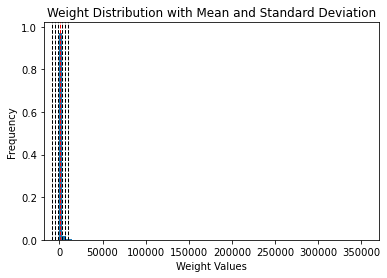

In [14]:
plot_weights_mean_and_std(user_artists, 0)

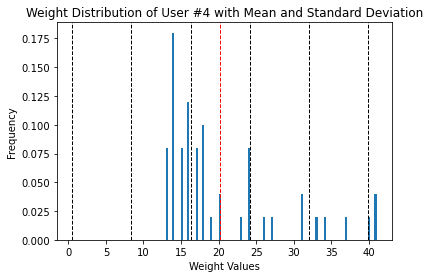

In [15]:
plot_weights_mean_and_std(user_artists, 4)

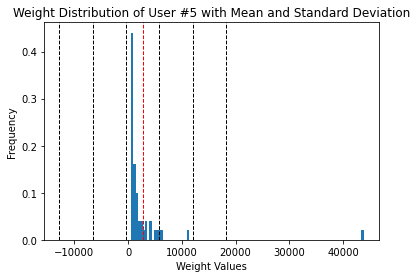

In [16]:
plot_weights_mean_and_std(user_artists, 5)

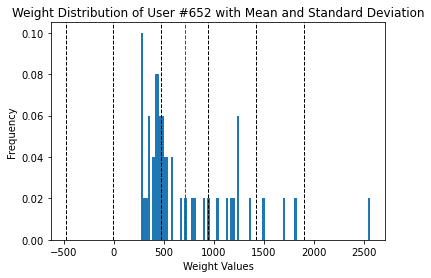

In [17]:
plot_weights_mean_and_std(user_artists, 652)

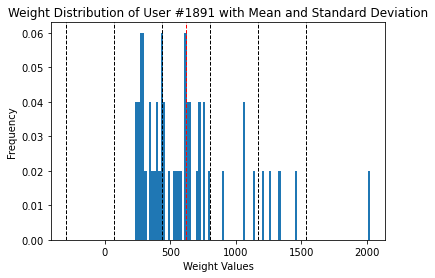

In [18]:
plot_weights_mean_and_std(user_artists, 1891)

These five graphs show us that using the mean and standard deviation as a method to assign our-star ratings, it would have some key performance issues.

This method does not prove very efficient as there are no occurrences of a 1-star rating for all users examined. It also does not apply to users who have outlier-like values, such as user #5 having one occurence of a weight above 40,000 which increases the standard deviation substantially, and results in majority of their weights belonging to the 3-star rating zone.

This issue with user #5 could be solved with outlier exclusion. Excluding outliers will reduce the size of the standard deviation, allowing the assignment of ratings to be more spread out, which may solve the issue of 1-star ratings also.

## Removing Outliers for User #5

In [19]:
user5 = remove_users_outliers(user_artists, 5)
user5_mean = user5['weight'].mean()
user5_std = np.std(user5['weight'])

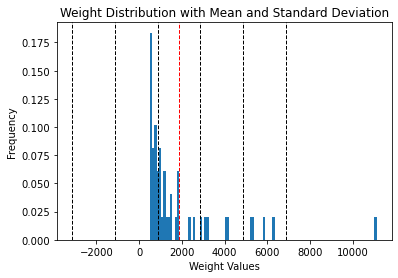

In [20]:
plot_weights_mean_and_std(user5)

The above graph shows slight improvement in comparison to the original graph contained in [this section](#plotting_mean_std) where the means and standard deviations were graphed.

Using the adjusted data, the datapoint above 1,000 could be considered a datapoint, and we can iterate through the outlier exclusion process again. We can explore this later.

Since there is only a sample set of 5 users, they may not be representative of the group of users. Let's assign the user ratings according to the normal distribution (mean and standard deviation), and see what adjustments can be made post-hoc.

# Creating a Loop to add Star-Ratings based on Normal Distribution

In [21]:
means_and_stds = find_means_and_stds_per_user(user_artists)
means = means_and_stds[0]
stds = means_and_stds[1]

In [22]:
user_artists['rating'] = 0
user_artists['mean'] = 0
user_artists['std'] = 0

In [23]:
user_artists['mean'] = user_artists.apply(lambda row: find_mean(row, means), axis=1)
user_artists['std'] = user_artists.apply(lambda row: find_std(row, stds), axis=1)
user_artists['rating'] = user_artists.apply(lambda row: find_rating(row), axis=1)

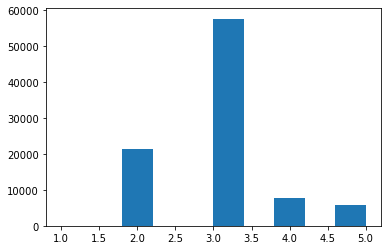

In [24]:
plt.hist(user_artists['rating']);

There are no artists that recieved a 1-star rating, this is due to the fact that the users' weights are not normally distributed, they're long-tailed distributions. 

This causes the standard deviation to be larger, meaning that most of the weights to the left of the mean will be within 1 standard deviation of the mean, resulting in no 1-star ratings.

We can check now if removing the outliers will make a difference to the distribution of star ratings.

## Adjusting Star-Ratings to Allow for Outlier Exclusion

In [25]:
## Removing any weight that is above 2 standard deviations away from the mean
adjusted_user_artists = user_artists[abs(user_artists['weight']-user_artists['mean'])<(2*user_artists['std'])]

In [26]:
## Dropping and recreating the mean, standard deviation and rating columns
adjusted_user_artists = adjusted_user_artists.drop(['std', 'rating', 'mean'], axis=1)

adjusted_user_artists['rating'] = 0
adjusted_user_artists['mean'] = 0
adjusted_user_artists['std'] = 0

In [27]:
means_and_stds = find_means_and_stds_per_user(adjusted_user_artists)
means = means_and_stds[0]
stds = means_and_stds[1]

In [28]:
## Recalculate the means, standard deviations and ratings

adjusted_user_artists['mean'] = adjusted_user_artists.apply(lambda row: find_mean(row, means), axis=1)
adjusted_user_artists['std'] = adjusted_user_artists.apply(lambda row: find_std(row, stds), axis=1)
adjusted_user_artists['rating'] = adjusted_user_artists.apply(lambda row: find_rating(row), axis=1)

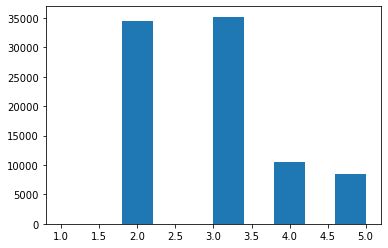

In [29]:
plt.hist(adjusted_user_artists['rating'], bins=10);

The adjustment didn't have a huge effect on the final allocation of ratings, there are still a large number of weights on the tail of the distribution that are skewing the ratings.

A next possible option would be to filter the data where weights are below 2328, as we found that this exludes the top 5% of values that could be skewing the data.

## Adding Star Ratings Excluding the Top 5% of Weights

In [30]:
adjusted_user_artists = user_artists[user_artists['weight']<=2328]

In [31]:
## Dropping and recreating the mean, standard deviation and rating columns
adjusted_user_artists = adjusted_user_artists.drop(['std', 'rating', 'mean'], axis=1)

adjusted_user_artists['rating'] = 0
adjusted_user_artists['mean'] = 0
adjusted_user_artists['std'] = 0

In [32]:
## Finding the new means and standard deviations
means_and_stds = find_means_and_stds_per_user(adjusted_user_artists)
means = means_and_stds[0]
stds = means_and_stds[1]

In [33]:
## Recalculate the means, standard deviations and ratings
adjusted_user_artists['mean'] = adjusted_user_artists.apply(lambda row: find_mean(row, means), axis=1)
adjusted_user_artists['std'] = adjusted_user_artists.apply(lambda row: find_std(row, stds), axis=1)
adjusted_user_artists['rating'] = adjusted_user_artists.apply(lambda row: find_rating(row), axis=1)

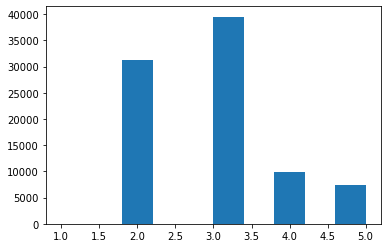

In [34]:
plt.hist(adjusted_user_artists['rating']);

Still have the same issue, let's investigate what proportion of users' weights are less than their mean.

## Investigating Proportion of Weights below Mean

In [35]:
## Finding the new means and standard deviations
means_and_stds = find_means_and_stds_per_user(adjusted_user_artists)
means = means_and_stds[0]
stds = means_and_stds[1]

In [36]:
below_mean = {}
weights = []
for userID in adjusted_user_artists.userID.unique():
    total = 0
    below_means_count = 0
    user_data = user_artists[user_artists['userID']==userID]
    for weight in user_data['weight']:
        if weight <= means[userID]:
            below_means_count += 1
            weights.append(weight)
        total += 1
    below_mean[userID] = below_means_count/total

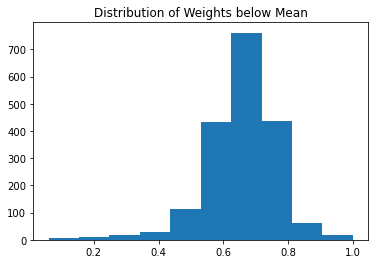

In [37]:
plt.hist(below_mean.values())
plt.gca().set(title='Distribution of Weights below Mean');

Judging by this graph, almost all of the users have most of their weights lower than their mean, meaning that there are few very large weights that are causing this increase in the mean.

## Final Decision

There is no one-size-fits-all for each user, as each user's listening habits are different.

The standard deviation cannot be used as the values to the left of the mean are distributed differently to the values on the right side of the mean, so we should introduce a split at the mean.

1. Find the mean
2. Find the minimum, and find the range of weights between the minimum and the mean.
3. Adjust the ratings so this range is divided into 25%, 50%, 25% for 1-star, 2-star and 3-star ratings respectively.
4. Find the maximum (up to a limit), and find the range of weights between the mean and the maximum.
5. Adjust the ratings so this range is divided into 25%, 50%, 25% for 3-star, 4-star and 5-star ratings respectively.

The weights will not be distributed evenly, the percentages will be calculated as minimum + ((mean - min) * 0.25) for the 1-star ratings, for example.

In [38]:
user_artists.drop('std', axis=1, inplace=True)
user_artists['mean'] = 0
user_artists['min'] = 0
user_artists['max'] = 0
user_artists['rating'] = 0

In [39]:
## Creating a dictionary to discover each users mean and standard deviation
means = {}
mins = {}
maxs = {}
for userID in user_artists.userID.unique():
    user_data = user_artists[user_artists['userID']==userID]
    user_mean = user_data['weight'].mean()
    user_min = user_data['weight'].min()
    user_max = user_data['weight'].max()
    means[userID] = user_mean
    mins[userID] = user_min
    maxs[userID] = user_max    

In [40]:
def find_mean(row, dict):
    return dict[row['userID']]

def find_min(row, dict):
    return dict[row['userID']]

def find_max(row, dict):
    return dict[row['userID']]

In [41]:
user_artists['mean'] = user_artists.apply(lambda row: find_mean(row, means), axis=1)
user_artists['min'] = user_artists.apply(lambda row: find_min(row, mins), axis=1)
user_artists['max'] = user_artists.apply(lambda row: find_max(row, maxs), axis=1)

In [42]:
def find_rating(row):
    weight = row['weight']
    user_mean = row['mean']
    user_min = row['min']
    user_max = row['max']
    ## Adjusting the max to 3000 to preserve distribution
    if user_max > 3000:
        user_max = 3000
    if weight <= (user_min + ((user_mean - user_min) * 0.25)):
        return 1
    elif weight <= (user_min + ((user_mean - user_min) * 0.75)):
        return 2
    elif weight <= user_max - ((user_max - user_mean) * 0.75):
        return 3
    elif weight <= user_max - ((user_max - user_mean) * 0.25):
        return 4
    else:
        return 5

In [43]:
user_artists['rating'] = user_artists.apply(lambda row: find_rating(row), axis=1)

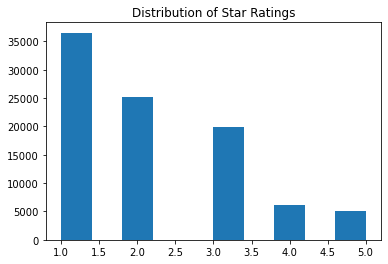

In [44]:
plt.hist(user_artists['rating'])
plt.gca().set(title='Distribution of Star Ratings');

This method seems to have an accurate representation of ratings, it is easier to listen to several artists just once and skip them than it is to listen to several artists thousands of times each. 

We need to use these ratings for our recommender system, so we will remove unnecessary columns from the dataframe and export it as a CSV file into our data directory.

In [45]:
user_artists.drop(['mean', 'min', 'max'], axis = 1, inplace = True)

In [46]:
user_artists

,userID,artistID,weight,rating
0,0,45,13883,5
1,0,46,11690,5
2,0,47,11351,5
3,0,48,10300,5
4,0,49,8983,5
...,...,...,...,...
92829,1891,17615,337,2
92830,1891,17616,297,1
92831,1891,17617,281,1
92832,1891,17618,280,1


In [47]:
user_artists.to_csv('../data/user_artists_ratings.csv', index=False)